# Evaluation/Testing

In [1]:
import pickle
import torch
import pandas as pd
import torch.nn as nn
import numpy as np

import scripts.data_loader as data_loader
import src.training as training
import src.evaluation as evaluation

from dataclasses import dataclass, asdict
from src.types import *
from src.utils.confusion_matrix import ConfusionMatrix
from src.models.main_model import OB_05Model
from scripts.visualization.model_evaluation import TestingVisualizations, TrainingVisualizations


cm = ConfusionMatrix
cm_macro = ConfusionMatrix.Macro
cm_micro = ConfusionMatrix.Micro

Deserializing/Loading the training logger

In [2]:
with open("models/training_logger.pkl", "rb") as file:
    training_logger = pickle.load(file)

# print(training_logger)

Loading the test dataset then creating a data loader from it

In [3]:
loaded_testing_dataset = torch.load('models/testing_dataset.pth')
testing_set_loader = data_loader.create_data_loader(loaded_testing_dataset)

print(next(iter(loaded_testing_dataset)))

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 2)


In [4]:
model = OB_05Model()
model.load_state_dict(torch.load('models/best_model.pth'))
evaluation_results = evaluation.evaluate_model(model, testing_set_loader)

#### Macro/Micro metrics

In [ ]:
"""
confusion_matrix = evaluation_result.confusion_matrix

macro_precision, macro_recall, macro_f1_score, macro_accuracy = cm_macro.calculate_overall_metrics(confusion_matrix)
micro_precision, micro_recall, micro_f1_score, micro_accuracy = cm_micro.calculate_overall_metrics(confusion_matrix)
accuracy = (macro_accuracy + micro_accuracy) / 2  # should be the same for both

data = [[macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score, accuracy]]
tuples = [("macro", "precision"), ("macro", "recall"), ("macro", "f1_score"), ("micro", "precision"), ("micro", "recall"), ("micro", "f1_score"), ("", "accuracy")]

df = pd.DataFrame(data,
                  index=pd.Index(["model"]),
                  columns=pd.MultiIndex.from_tuples(tuples, names=["", "metrics"]))

df.style
"""

fig = TestingVisualizations.generate_overall_metrics_table(evaluation_results)
fig

#### Confusion matrix

In [ ]:
confusion_matrix = evaluation_result.confusion_matrix

df = pd.DataFrame(confusion_matrix,
                  index=pd.Index(["anger", "engaged", "happy", "neutral"]),
                  columns=pd.Index(["anger", "engaged", "happy", "neutral"]))
s = df.style
s

#### Confusion matrix analysis

In [ ]:
confusion_matrix = evaluation_result.confusion_matrix

precisions, recalls, f1_scores, accuracies = cm.calculate_per_class_metrics(confusion_matrix)
array = [precisions, recalls, f1_scores, accuracies]

df = pd.DataFrame(array, 
                  index=pd.Index(["precision", "recall", "f1_score", "accuracy"]),
                  columns=pd.Index(["anger", "engaged", "happy", "neutral"]))
# df
array

In [ ]:
import seaborn as sns

from pipe import *


def process_metrics(_data, metric_name):
    as_df = pd.DataFrame(_data, columns=["score"])
    as_df.insert(0, "class", ["anger", "engaged", "happy", "neutral"])
    as_df.insert(1, "metric", metric_name)
    # as_df[metric_name] = metric_name
    return as_df 

precisions, recalls, f1_scores, accuracies = cm.calculate_per_class_metrics(confusion_matrix)

processed_precisions = process_metrics(precisions, "precision")
processed_recalls = process_metrics(recalls, "recall")
processed_f1_scores = process_metrics(f1_scores, "f1_score")
processed_accuracies = process_metrics(accuracies, "accuracy")

df = pd.concat([processed_precisions, processed_recalls, processed_f1_scores, processed_accuracies])
df

In [ ]:
g = sns.catplot(df, kind="bar", x="class", y="score", hue="metric",
                errorbar="sd", alpha=0.6, height=6)
g.despine(left=True, bottom=True)
g.legend.set_title("metric")

# Metrics per class

In [ ]:
fig = TestingVisualizations.plot_metrics_per_class(evaluation_results)
fig

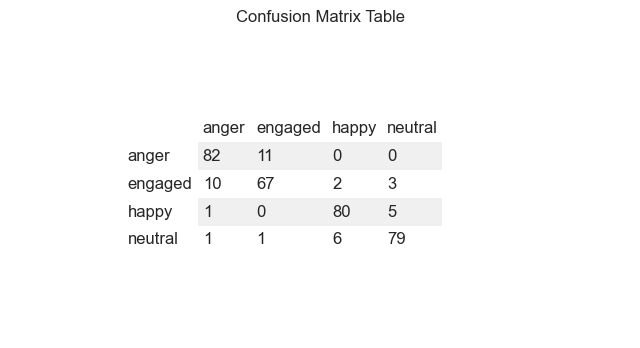

In [8]:
fig = TestingVisualizations.generate_confusion_matrix_table(evaluation_results)
fig


In [ ]:
from pipe import *

confusion_matrix = evaluation_results.confusion_matrix
precisions, recalls, f1_scores, accuracies = cm.calculate_per_class_metrics(confusion_matrix)

def floats_to_strings(_data):
    return list(_data | select(lambda x: f"{x:.4f}"))

floats_to_strings(list(precisions))